In [ ]:
# Mount Google Colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd '/content/gdrive/My Drive/Masters_Thesis'


Mounted at /content/gdrive
/content/gdrive/My Drive/Masters_Thesis


In [ ]:
!pip install stepmix # library used to build LCA model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from stepmix.stepmix import StepMix

from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

np.random.seed(42) # seed for reproducibility

In [ ]:
# Provide the filename of your Excel file
file_name = 'uu_preprocessed.xlsx'

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_name)

#Splitting data into answers for personality test

In [ ]:
personality = df[df['maingroup'] == 'Beroepskeuzetest'] # Subset to only include personality questions

# Specify the columns to keep
columns_to_keep = ['question_id', 'maingroup', 'level1subgroup']

# Subset the personality dataframe using the specified columns
pers = personality.loc[:, columns_to_keep]

pers = pers.drop(['maingroup'], axis=1)
qs = pers.drop_duplicates(subset='question_id')
qs = qs.sort_values('level1subgroup')
qs

# Create the 'short_name' column
qs['short_name'] = ''

# Find rows containing e.g. 'Artistiek' and append them to the 'short_name' column
# This is done so to reformat the data
count_a = 1
count_c = 1
count_i = 1
count_o = 1
count_r = 1
count_s = 1
for index, row in qs.iterrows():
    if row['level1subgroup'] == 'Artistiek':
        qs.at[index, 'short_name'] = f'art{count_a}'
        count_a += 1

    elif row['level1subgroup'] == 'Conventioneel':
        qs.at[index, 'short_name'] = f'con{count_c}'
        count_c += 1

    elif row['level1subgroup'] == 'Intellectueel':
        qs.at[index, 'short_name'] = f'int{count_i}'
        count_i += 1

    elif row['level1subgroup'] == 'Ondernemend':
        qs.at[index, 'short_name'] = f'ond{count_o}'
        count_o += 1

    elif row['level1subgroup'] == 'Realistisch':
        qs.at[index, 'short_name'] = f'rea{count_r}'
        count_r += 1
    else:
        qs.at[index, 'short_name'] = f'soc{count_s}'
        count_s += 1

qs

,question_id,level1subgroup,short_name
107,2230,Artistiek,art1
62,2300,Artistiek,art2
63,2304,Artistiek,art3
64,2299,Artistiek,art4
66,2302,Artistiek,art5
...,...,...,...
22,2272,Sociaal,soc14
59,2307,Sociaal,soc15
20,2271,Sociaal,soc16
92,2234,Sociaal,soc17


In [ ]:
n_qs = qs.drop(['level1subgroup'], axis=1)

# merging (left join) studeies to orginal dataframe
new_qs = pd.merge(personality, n_qs, on='question_id', how='left')
new_qs.head(3)

,dossier_id,question_id,answer,label,maingroup,maingroup_id,level1subgroup,level1subgroup_id,faculty,short_name
0,1152,2281,0.75,rapporten schrijven,Beroepskeuzetest,459.0,Conventioneel,457,Faculteit Geesteswetenschappen,con15
1,1152,2263,0.75,intuïtief zijn,Beroepskeuzetest,459.0,Artistiek,454,Faculteit Geesteswetenschappen,art16
2,1152,2269,0.75,je gevoelens duidelijk uiten,Beroepskeuzetest,459.0,Sociaal,455,Faculteit Geesteswetenschappen,soc1


In [ ]:
# Create the qs_data pivot table df
qs_data = pd.pivot_table(new_qs, values='answer', index='dossier_id', columns='short_name')

# Reset the index of 'qs_data'
qs_data = qs_data.reset_index()
qs_data = qs_data.rename_axis(None, axis=1)

# Remove NANs
qs_data.replace('', np.nan, inplace=True)
qs_data = qs_data.dropna()
qs_data

,dossier_id,art1,art10,art11,art12,art13,art14,art15,art16,art17,...,soc17,soc18,soc2,soc3,soc4,soc5,soc6,soc7,soc8,soc9
0,1152,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.75,0.25,...,0.75,0.75,0.50,1.00,0.75,0.50,0.25,1.00,0.75,1.00
1,1532,0.75,0.25,1.00,0.50,0.00,0.50,0.75,0.75,0.50,...,0.50,1.00,0.75,1.00,1.00,1.00,0.50,0.75,1.00,0.75
2,1649,0.75,1.00,1.00,0.75,0.75,0.25,0.75,1.00,0.75,...,1.00,0.00,0.50,1.00,1.00,1.00,0.75,1.00,0.25,0.75
3,1663,1.00,1.00,1.00,0.75,0.75,0.75,0.75,1.00,0.50,...,1.00,1.00,1.00,1.00,1.00,1.00,0.75,1.00,0.75,0.75
4,2112,0.75,0.75,1.00,0.50,0.50,0.50,0.75,0.50,0.25,...,0.50,0.75,1.00,1.00,1.00,1.00,0.50,0.75,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,91894,0.75,0.25,1.00,0.50,0.75,0.25,0.75,0.75,1.00,...,0.75,0.50,0.25,1.00,0.75,0.75,0.25,0.75,0.75,0.50
745,91908,1.00,0.75,0.75,0.25,0.25,0.50,0.75,0.75,0.25,...,0.75,1.00,0.75,0.25,1.00,0.75,0.50,0.75,0.75,0.50
746,91927,0.75,0.25,0.50,0.25,0.25,0.50,0.75,0.75,0.75,...,0.75,0.50,0.75,0.75,0.75,0.50,0.25,0.75,0.75,0.75
747,91928,0.75,0.50,0.75,0.75,0.00,0.75,0.50,0.75,0.00,...,0.75,0.75,0.75,1.00,0.75,0.50,0.25,0.75,0.75,1.00


In [ ]:
model = qs_data.drop('dossier_id', axis=1)

# Define a custom sorting function to sort the columns in alphabetical and numerical order
def custom_sort(column):
    prefix = column[:-1]  # Extract the prefix (e.g., "art" or "soc")
    suffix = int(column[-1])  # Extract the numerical suffix
    return prefix, suffix

# Get the column names and sort them using the custom sort function
sorted_columns = sorted(model.columns, key=custom_sort)

# Assign the sorted column names back to the DataFrame
model = model[sorted_columns]
model

# New df for LCA to ensure not manipulated in kmeans methods
data_lca = model

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

# creating X variable to use as to not effect the model data
X = model

# Range of cluster numbers to test
n_clusters_range = range(2, 10)
wcss = [] # list to contain wcss values for Elbow method

# Dictionaries to store the metrics
metrics = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
    'n_clusters': []
}

# Loop over the cluster numbers and perform clustering
for i, n_clusters in enumerate(n_clusters_range):

    # Run hierarchical clustering using the ward linkage method
    ward_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ward_cluster.fit(X)

    #Extract the labels and linkage matrix
    ward_labels = ward_cluster.labels_
    linkage_matrix = ward_cluster.children_

    # Extract the cluster centroids from the linkage matrix
    centroids = []
    for j in range(n_clusters):
        indices = ward_labels == j
        centroid = X[indices].mean(axis=0)
        centroids.append(centroid)
    kmeans_cluster = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=0)
    kmeans_cluster.fit(X)
    cluster_labels = kmeans_cluster.labels_

    # Calculate the metrics for the current cluster assignment
    inertia = kmeans_cluster.inertia_
    silhouette = silhouette_score(X, kmeans_cluster.labels_)
    calinski_harabasz = calinski_harabasz_score(X, kmeans_cluster.labels_)
    davies_bouldin = davies_bouldin_score(X, kmeans_cluster.labels_)

    # Store the metrics in the dictionary
    metrics['silhouette'].append(silhouette)
    metrics['calinski_harabasz'].append(calinski_harabasz)
    metrics['davies_bouldin'].append(davies_bouldin)
    metrics['n_clusters'].append(n_clusters)
    wcss.append(kmeans_cluster.inertia_)

# Convert the metrics dictionary to dataframe
metrics_df = pd.DataFrame(metrics)

metrics_df

,silhouette,calinski_harabasz,davies_bouldin,n_clusters
0,0.079637,64.243595,3.243757,2
1,0.075601,48.099817,2.995175,3
2,0.052461,42.849908,3.024239,4
3,0.037757,35.836299,3.405310,5
4,0.030209,32.361475,3.497270,6
5,0.026653,29.313518,3.408381,7
6,0.027321,26.620659,3.366402,8
7,0.022717,24.548024,3.340526,9


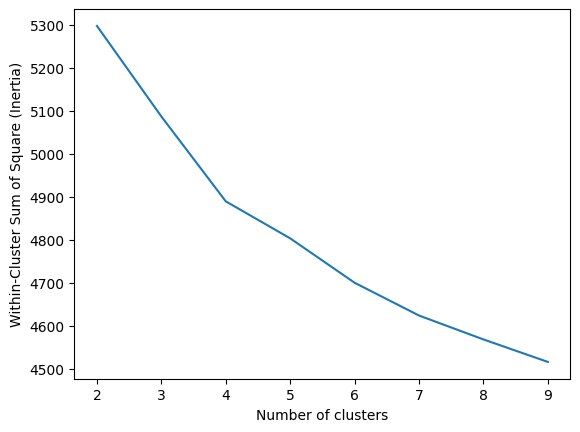

In [ ]:
# Plot Elbow
plt.plot(n_clusters_range, wcss)
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Square (Inertia)')
plt.show()

<Axes: xlabel='PC1', ylabel='PC2'>

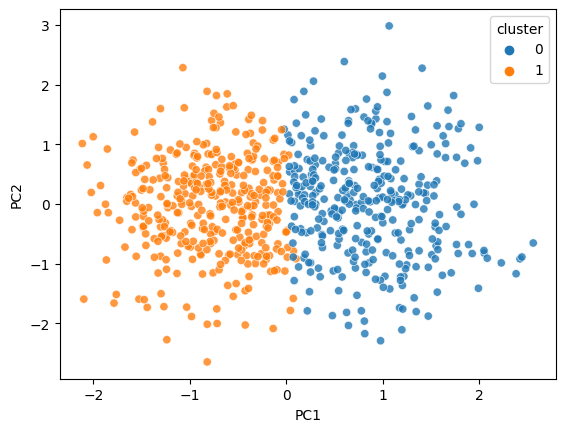

In [ ]:
# Create Kmeans Cluster Model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

seed = 1234  # Used for reproducibility

kmeans = KMeans(n_clusters=2, n_init = 10, random_state=seed)
k_fit = kmeans.fit(model)
centroids = kmeans.cluster_centers_
predictions = k_fit.labels_

# Develop 2 PCA components for visualizations
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(model),columns=['PC1','PC2'])

# To maintain cluster colours to allow for easier comparison between cluster plots
colour_dict = dict({0: sns.color_palette("tab10")[1], 1: sns.color_palette("tab10")[0]})

pca_data['cluster'] = pd.Categorical(predictions)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data, palette="tab10", alpha=0.8)

In [ ]:
#pca_data.to_excel('before_pers_clusters.xlsx', index=False)

# Plotting each individual test together

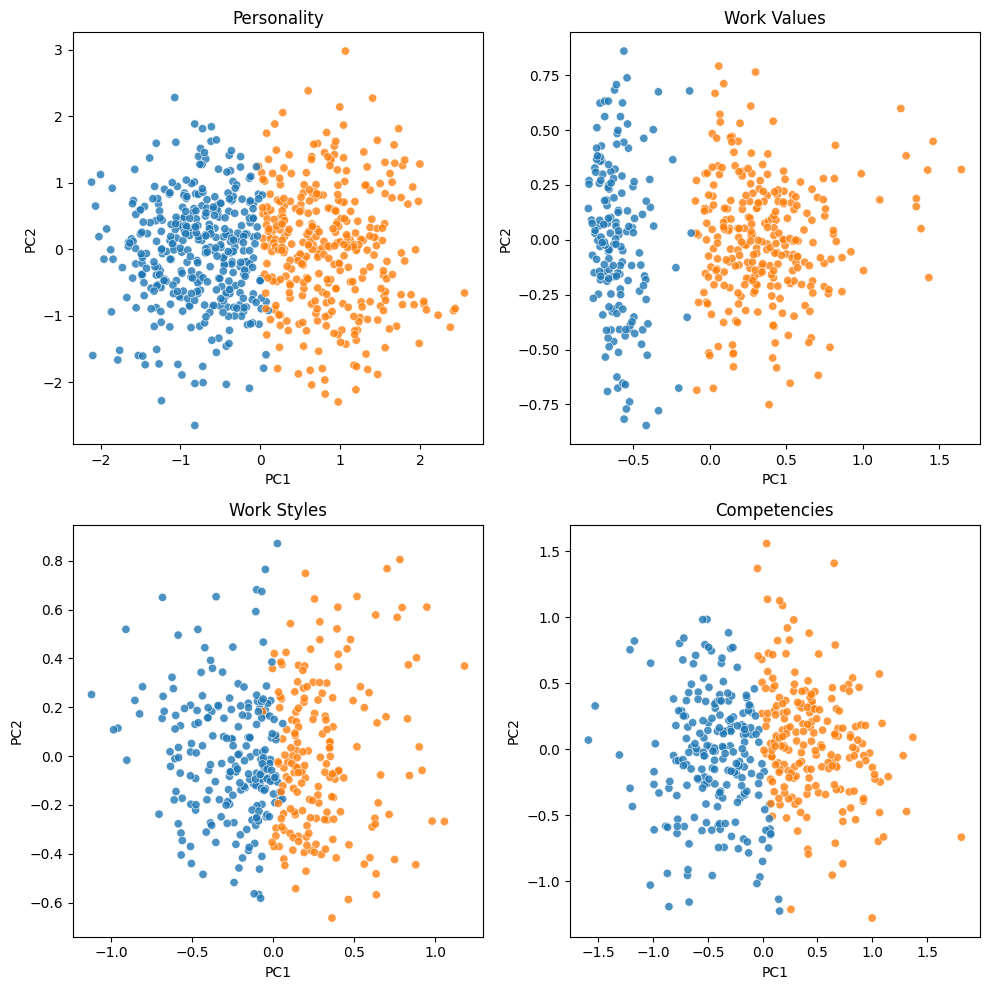

In [ ]:
# Before PCA
pca1 = pca_data
pca2 = pd.read_excel('before_work_v_clusters.xlsx')
pca3 = pd.read_excel('before_work_s_clusters.xlsx')
pca4 = pd.read_excel('before_skills_clusters.xlsx')
pca5 = pd.read_excel('ALL_TESTS_clusters.xlsx')

# PCASC
pcaSC1 = pd.read_excel('pcaSC_pers_clusters.xlsx')
pcaSC2 = pd.read_excel('pcaSC_work_v_clusters.xlsx')
pcaSC3 = pd.read_excel('pcaSC_work_s_clusters.xlsx')
pcaSC4 = pd.read_excel('pcaSC_skills_clusters.xlsx')
pcaSC5 = pd.read_excel('pcaSC_ALL_TESTS_clusters.xlsx')

# PCACV
pcaCV1 = pd.read_excel('pcaCV_pers_clusters.xlsx')
pcaCV2 = pd.read_excel('pcaCV_work_v_clusters.xlsx')
pcaCV3 = pd.read_excel('pcaCV_work_s_clusters.xlsx')
pcaCV4 = pd.read_excel('pcaCV_skills_clusters.xlsx')
pcaCV5 = pd.read_excel('pcaCV_ALL_TESTS_clusters.xlsx')

# Create a figure and subplots with a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot PCA 1 in the top left quadrant
colour_dict = dict({0: sns.color_palette("tab10")[1], 1: sns.color_palette("tab10")[0]})
sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca1, palette=colour_dict, alpha=0.8, ax=axes[0, 0])
axes[0, 0].set_title('Personality')
axes[0, 0].get_legend().remove()

# Plot PCA 2 in the top right quadrant
sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca2, palette='tab10', alpha=0.8, ax=axes[0, 1])
axes[0, 1].set_title('Work Values')
axes[0, 1].get_legend().remove()

# Plot PCA 3 in the bottom left quadrant
sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca3, palette='tab10', alpha=0.8, ax=axes[1, 0])
axes[1, 0].set_title('Work Styles')
axes[1, 0].get_legend().remove()

# Plot PCA 4 in the bottom right quadrant
sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca4, palette='tab10', alpha=0.8, ax=axes[1, 1])
axes[1, 1].set_title('Competencies')
axes[1, 1].get_legend().remove()

# tight layout
plt.tight_layout()
plt.show()


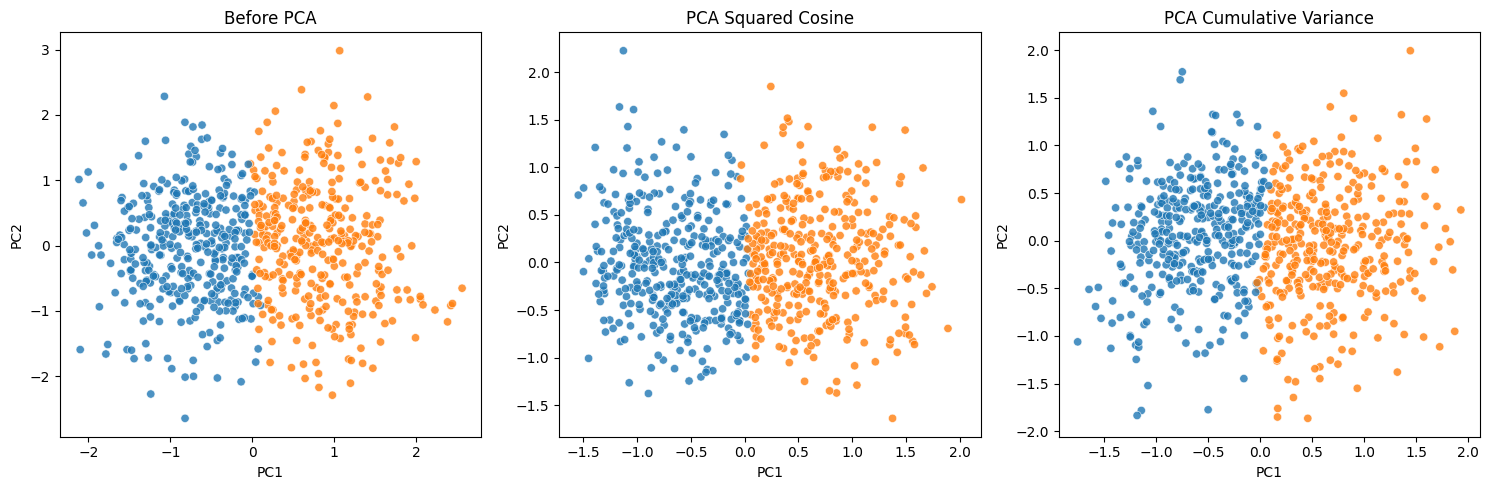

In [ ]:
# to save space in this notebook I am going to run this for each test by switching variables after ever run instead of having 5 seperate code chunks for each test

# Create a figure and subplots with a 1x3 grid
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colour_dict = dict({0: sns.color_palette("tab10")[1], 1: sns.color_palette("tab10")[0]})

# Plot PCA 1 in the first subplot
sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca1, palette=colour_dict, alpha=0.8, ax=axes[0])
axes[0].set_title('Before PCA')
axes[0].get_legend().remove()

# Plot PCA 2 in the second subplot
sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pcaSC1, palette=colour_dict, alpha=0.8, ax=axes[1])
axes[1].set_title('PCA Squared Cosine')
axes[1].get_legend().remove()

# Plot PCA 3 in the third subplot
sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pcaCV1, palette='tab10', alpha=0.8, ax=axes[2])
axes[2].set_title('PCA Cumulative Variance')
axes[2].get_legend().remove()

plt.tight_layout()
plt.show()


#Latent Class Analysis

In [ ]:
from sklearn.model_selection import ParameterGrid

# Using Stepmix library function to create LCA model
model = StepMix(n_components=3, measurement="categorical", verbose=1, random_state=123, n_init=10)

# Tested by all n_steps range but found they are all equal for all results and therefore will just use n_step=1
grid = {
    'n_components': [2, 3, 4, 5, 6, 7, 8, 9],
    'n_steps' : [1]
}

results = dict(param_n_steps=[], param_n_components=[], aic=[], bic=[])

# Same model and grid as above
for g in ParameterGrid(grid):
    model.set_params(**g)
    model.fit(data_lca)
    results['param_n_steps'].append(g['n_steps'])
    results['param_n_components'].append(g['n_components'])
    results['aic'].append(model.aic(data_lca))
    results['bic'].append(model.bic(data_lca))

# Save results to a dataframe
results = pd.DataFrame(results)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:12<00:00,  1.28s/it, max_LL=-3.2e+4, max_avg_LL=-44.9]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 108 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.5149 0.4851 0.6541 0.3459 0.6455 0.3545 0.5182 0.4818 0.6476 0.3524
 0.7270 0.2730 0.9176 0.0824 0.8812 0.1188 0.6744 0.3256 0.6596 0.3404
 0.5128 0.4872 0.8771 0.1229 0.8336 0.1664 0.8941 0.1059 0.7750 0.2250
 0.6805 0.3195 0.8887 0.1113 0.7246 0.2754 0.6721 0.3279 0.6716 0.3284
 0.6923 0.3077 0.7890 0.2110 0.5625 0.4375 0.8870 0.1130 0.6227 0.3773
 0.8314 0.1686 0.7639 0.2361 0.7862 0.2138 0.7219 0.2781 0.9163 0.0837
 0.7344 0.2656 0.7770 0.2230 0.8271 0.1729 0.6505 0.3495 0.7617 0.2383
 0.7112 0.2888 0.6820 0.3180 0.5803 0.4197 0.4710 0.5290 0.8403 0

Initializations (n_init) : 100%|██████████| 10/10 [00:21<00:00,  2.17s/it, max_LL=-3.13e+4, max_avg_LL=-43.8]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 108 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.6962 0.3038 0.6654 0.3346 0.6682 0.3318 0.6293 0.3707 0.6210 0.3790
 0.7722 0.2278 0.9271 0.0729 0.8607 0.1393 0.7379 0.2621 0.7552 0.2448
 0.5120 0.4880 0.9610 0.0390 0.8571 0.1429 0.8739 0.1261 0.8769 0.1231
 0.8283 0.1717 0.8895 0.1105 0.8469 0.1531 0.6839 0.3161 0.6227 0.3773
 0.6884 0.3116 0.7523 0.2477 0.6487 0.3513 0.8669 0.1331 0.6486 0.3514
 0.8012 0.1988 0.8953 0.1047 0.8311 0.1689 0.8508 0.1492 0.9000 0.1000
 0.6950 0.3050 0.8018 0.1982 0.8680 0.1320 0.8706 0.1294 0.6928 0.3072
 0.7450 0.2550 0.6452 0.3548 0.6196 0.3804 0.3924 0.6076 0.8045 0

Initializations (n_init) : 100%|██████████| 10/10 [00:30<00:00,  3.05s/it, max_LL=-3.07e+4, max_avg_LL=-43]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 108 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.6355 0.3645 0.2886 0.7114 0.6071 0.3929 0.5203 0.4797 0.3483 0.6517
 0.9030 0.0970 0.9475 0.0525 0.9474 0.0526 0.8415 0.1585 0.4805 0.5195
 0.5413 0.4587 0.9883 0.0117 0.8468 0.1532 0.9775 0.0225 0.8039 0.1961
 0.7595 0.2405 0.9373 0.0627 0.8838 0.1162 0.7269 0.2731 0.3128 0.6872
 0.6721 0.3279 0.8081 0.1919 0.7274 0.2726 1.0000 0.0000 0.8408 0.1592
 0.9772 0.0228 0.8842 0.1158 0.9525 0.0475 0.8535 0.1465 0.9572 0.0428
 0.6376 0.3624 0.9419 0.0581 0.9456 0.0544 0.8296 0.1704 0.9202 0.0798
 0.9099 0.0901 0.4939 0.5061 0.7450 0.2550 0.3484 0.6516 0.9208 0

Initializations (n_init) : 100%|██████████| 10/10 [00:38<00:00,  3.84s/it, max_LL=-3.01e+4, max_avg_LL=-42.2]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 108 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.6315 0.3685 0.3179 0.6821 0.5717 0.4283 0.4748 0.5252 0.3883 0.6117
 0.8786 0.1214 0.9211 0.0789 0.9332 0.0668 0.8439 0.1561 0.5014 0.4986
 0.5332 0.4668 0.9857 0.0143 0.8279 0.1721 0.9801 0.0199 0.8089 0.1911
 0.7588 0.2412 0.9144 0.0856 0.8865 0.1135 0.7369 0.2631 0.3494 0.6506
 0.6689 0.3311 0.8149 0.1851 0.7214 0.2786 1.0000 0.0000 0.8144 0.1856
 0.9803 0.0197 0.8600 0.1400 0.9250 0.0750 0.8246 0.1754 0.9613 0.0387
 0.6462 0.3538 0.9233 0.0767 0.9400 0.0600 0.7865 0.2135 0.9095 0.0905
 0.9004 0.0996 0.5526 0.4474 0.7368 0.2632 0.3607 0.6393 0.9315 0

Initializations (n_init) : 100%|██████████| 10/10 [00:44<00:00,  4.48s/it, max_LL=-2.98e+4, max_avg_LL=-41.7]

MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 108 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.8222 0.1778 0.9154 0.0846 0.9235 0.0765 0.7922 0.2078 0.8039 0.1961
 0.9045 0.0955 1.0000 0.0000 0.9594 0.0406 0.8702 0.1298 0.8867 0.1133
 0.5881 0.4119 1.0000 0.0000 0.9715 0.0285 0.8386 0.1614 0.9691 0.0309
 0.8805 0.1195 0.8964 0.1036 0.8988 0.1012 0.5504 0.4496 0.6506 0.3494
 0.6292 0.3708 0.6318 0.3682 0.6147 0.3853 0.7183 0.2817 0.4445 0.5555
 0.6399 0.3601 0.8067 0.1933 0.7805 0.2195 0.7653 0.2347 0.8116 0.1884
 0.7516 0.2484 0.6279 0.3721 0.8105 0.1895 0.7798 0.2202 0.5482 0.4518
 0.5631 0.4369 0.6301 0.3699 0.7430 0.2570 0.5199 0.4801 0.6678 0

In [ ]:
# Printing desired AIC and BIC values from Stepmix
results[['param_n_components', 'aic', 'bic']].round().astype(int)


,param_n_components,aic,bic
0,2,64510,65502
1,3,63177,64667
2,4,62228,64216
3,5,61328,63814
4,6,60833,63817
